In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils
import torch.utils.data
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from math import pi
import pickle
import time

device = torch.device('cpu')


In [2]:
# Define the exact solution
def exact_solution_u(x, t):
    return (2.5*pi*torch.cos(x)+(x-pi*2.5))*torch.cos(t)

def initial_condition_u(x):
    return 2.5*pi*torch.cos(x) + (x - pi*2.5)

def initial_condition_u_t(x):
    return 0.0*pi*torch.cos(x)

# Define the exact solution
def exact_solution_p(x, t):
    return 2.5*pi*torch.sin(x)*torch.cos(t)

def initial_condition_p(x):
    return 2.5*pi*torch.sin(x)

def initial_condition_p_t(x):
    return 0.0*pi*torch.cos(x)

# assigning number of points
initial_pts = 500
left_boundary_pts = 500
right_boundary_pts = 500
residual_pts = 10000

# Type of optimizer (ADAM or LBFGS)
opt_type = "LBFGS"

eps = 5
manualSeed = 1

#np.random.seed(manualSeed)
#random.seed(manualSeed)
torch.manual_seed(manualSeed)

x_init = 9*pi*torch.rand((initial_pts,1)) # initial pts
t_init = 0*x_init
init =  torch.cat([x_init, t_init],1).to(device)
u_init = initial_condition_u(init[:,0]).reshape(-1, 1).to(device)
p_init = initial_condition_p(init[:,0]).reshape(-1, 1).to(device)
w_init = torch.cat([u_init, p_init],1).to(device)

u_t_init = initial_condition_u_t(init[:,0]).reshape(-1, 1).to(device)
p_t_init = initial_condition_p_t(init[:,0]).reshape(-1, 1).to(device)
w_t_init = torch.cat([u_t_init, p_t_init],1).to(device)



xb_left = torch.zeros((left_boundary_pts, 1)) # left spatial boundary
tb_left = torch.rand((left_boundary_pts, 1)) #
b_left = torch.cat([xb_left, tb_left ],1).to(device)
u_b_l = exact_solution_u(xb_left, tb_left).to(device)
p_b_l = exact_solution_p(xb_left, tb_left).to(device)
w_b_l = torch.cat([u_b_l, p_b_l],1).to(device)



xb_right = 9*pi*torch.ones((right_boundary_pts, 1)) # right spatial boundary
tb_right = torch.rand((right_boundary_pts, 1)) # right boundary pts
b_right = torch.cat([xb_right, tb_right ],1).to(device)
u_b_r = exact_solution_u(xb_right, tb_right).to(device)
p_b_r = exact_solution_p(xb_right, tb_right).to(device)
w_b_r = torch.cat([u_b_r, p_b_r],1).to(device)

# x_interior = pi*torch.rand((residual_pts, 1))
# t_interior = torch.rand((residual_pts, 1))
# interior = torch.cat([x_interior, t_interior],1)

x_int = torch.linspace(0, 9*pi, 102)
x_int = x_int[1:-1]

t_int = torch.linspace(0, 1, 102)
t_int = t_int[1:-1]

x_interior = x_int.tile((100,))
x_interior = x_interior.reshape(-1,1)

t_interior = t_int.repeat_interleave(100)
t_interior = t_interior.reshape(-1,1)

# torch.set_printoptions(threshold=10_000)

interior = torch.cat([x_interior, t_interior],1).to(device)

n = 100  # size of matrix
W = torch.tril(torch.ones(n, n), diagonal=-1).to(device)  # create a lower triangular matrix of ones
W -= torch.diag(torch.diag(W)).to(device)  # set the diagonal elements to zero




training_set = DataLoader(torch.utils.data.TensorDataset(init.to(device), w_init.to(device), w_t_init.to(device), b_left.to(device),  b_right.to(device)), batch_size=2000, shuffle=False)


In [3]:
class NeuralNet(nn.Module):

    def __init__(self, input_dimension, output_dimension, n_hidden_layers, neurons):
        super(NeuralNet, self).__init__()
        # Number of input dimensions n
        self.input_dimension = input_dimension
        # Number of output dimensions m
        self.output_dimension = output_dimension
        # Number of neurons per layer
        self.neurons = neurons
        # Number of hidden layers
        self.n_hidden_layers = n_hidden_layers
        # Activation function
        self.activation = nn.Tanh()

        self.input_layer = nn.Linear(self.input_dimension, self.neurons)
        self.hidden_layers = nn.ModuleList([nn.Linear(self.neurons, self.neurons) for _ in range(n_hidden_layers)])
        self.output_layer = nn.Linear(self.neurons, self.output_dimension)

    def forward(self, x):
        # The forward function performs the set of affine and non-linear transformations defining the network
        # (see equation above)
        x = self.activation(self.input_layer(x))
        for k, l in enumerate(self.hidden_layers):
            x = self.activation(l(x))
        return self.output_layer(x)

In [4]:
my_network = NeuralNet(input_dimension = init.shape[1], output_dimension = 2, n_hidden_layers=4, neurons=200)
model_state_dict = torch.load('causal_timo.pth', map_location=torch.device('cpu'))
my_network = my_network.to(device)

# after defining my network - also dont forget to comment xavier
my_network.load_state_dict(model_state_dict)

if opt_type == "ADAM":
    optimizer_ = optim.Adam(my_network.parameters(), lr=0.001)
elif opt_type == "LBFGS":
    optimizer_ = optim.LBFGS(my_network.parameters(), lr=0.1, max_iter=1, max_eval=50000, tolerance_change=1.0 * np.finfo(float).eps)
else:
    raise ValueError("Optimizer not recognized")


def fit(model, training_set, interior, num_epochs, optimizer, p, verbose=True):
    history = list()

    # Loop over epochs
    for epoch in range(num_epochs):
        if verbose: print("################################ ", epoch, " ################################")

        running_loss = list([0])

        # Loop over batches
        for j, (initial, w_initial, w_initial_t, bd_left, bd_right) in enumerate(training_set):
            def closure():
                # zero the parameter gradients
                optimizer.zero_grad()
                # for initial
                initial.requires_grad = True
                w_initial_pred_ = model(initial)
                u_initial_pred_ = w_initial_pred_[:, 0].reshape(-1, 1)
                p_initial_pred_ = w_initial_pred_[:, 1].reshape(-1, 1)

                # with derivative
                inpu = torch.ones(initial_pts, 1).to(device)

                grad_u_ini = \
                torch.autograd.grad(u_initial_pred_, initial, grad_outputs=inpu, create_graph=True, allow_unused=True)[
                    0]

                u_initial_t = grad_u_ini[:, 1]

                grad_p_ini = torch.autograd.grad(p_initial_pred_, initial, grad_outputs=inpu, create_graph=True)[0]

                p_initial_t = grad_p_ini[:, 1]

                # for left boundary
                w_bd_left_pred_ = model(bd_left)
                u_bd_left_pred_ = w_bd_left_pred_[:, 0].reshape(-1, 1)
                p_bd_left_pred_ = w_bd_left_pred_[:, 1].reshape(-1, 1)
                # for right boundary
                w_bd_right_pred_ = model(bd_right)
                u_bd_right_pred_ = w_bd_right_pred_[:, 0].reshape(-1, 1)
                p_bd_right_pred_ = w_bd_right_pred_[:, 1].reshape(-1, 1)

                # residual calculation
                interior.requires_grad = True
                w_hat = model(interior)
                u_hat = w_hat[:, 0].reshape(-1, 1)
                p_hat = w_hat[:, 1].reshape(-1, 1)
                inputs = torch.ones(residual_pts, 1).to(device)
                inputs2 = torch.ones(residual_pts, 1).to(device)
                grad_u_hat = \
                torch.autograd.grad(u_hat.reshape(-1, 1), interior, grad_outputs=inputs, create_graph=True)[0]

                u_x = grad_u_hat[:, 0].reshape(-1, 1)

                grad_u_hat_xx = torch.autograd.grad(u_x, interior, grad_outputs=inputs, create_graph=True)[0]

                u_xx = grad_u_hat_xx[:, 0].reshape(-1, 1)

                grad_p_hat = torch.autograd.grad(p_hat, interior, grad_outputs=inputs, create_graph=True)[0]

                p_x = grad_p_hat[:, 0].reshape(-1, 1)

                grad_p_hat_xx = torch.autograd.grad(p_x, interior, grad_outputs=inputs, create_graph=True)[0]

                p_xx = grad_p_hat_xx[:, 0].reshape(-1, 1)

                # grad_grad_u_x = torch.autograd.grad(u_x, interior, grad_outputs=torch.ones(interior.shape[0]), create_graph=True)[0]
                # u_xx = grad_grad_u_x[:, 0]
                u_t = grad_u_hat[:, 1].reshape(-1, 1)

                grad_u_hat_tt = torch.autograd.grad(u_t, interior, grad_outputs=inputs, create_graph=True)[0]

                u_tt = grad_u_hat_tt[:, 1].reshape(-1, 1)

                p_t = grad_p_hat[:, 1].reshape(-1, 1)
                grad_p_hat_tt = torch.autograd.grad(p_t, interior, grad_outputs=inputs, create_graph=True)[0]

                p_tt = grad_p_hat_tt[:, 1].reshape(-1, 1)

                pde_single_column = (u_tt.reshape(-1, ) - u_xx.reshape(-1, ) + u_hat.reshape(-1, ) - p_x.reshape(
                    -1, )) ** 2
                pde_single_column = pde_single_column.reshape(-1, 1)

                pde_matrix = pde_single_column.reshape(100, 100)

                loss_at_time_steps = torch.mean(pde_matrix, 1)
                loss_at_time_steps = loss_at_time_steps.reshape(-1, 1)

                with torch.no_grad():
                    weighted_loss = torch.matmul(W, loss_at_time_steps)
                weighted_loss = torch.exp(-eps * weighted_loss)

                loss_pde = torch.mean(weighted_loss * loss_at_time_steps)

                pde_single_column1 = (p_tt.reshape(-1, ) + u_x.reshape(-1, ) - p_xx.reshape(-1, ) + p_hat.reshape(
                    -1, ) - torch.cos(interior[:, 1]).reshape(-1, )) ** 2
                pde_single_column1 = pde_single_column1.reshape(-1, 1)

                pde_matrix1 = pde_single_column1.reshape(100, 100)

                loss_at_time_steps1 = torch.mean(pde_matrix1, 1)
                loss_at_time_steps1 = loss_at_time_steps1.reshape(-1, 1)

                with torch.no_grad():
                    weighted_loss1 = torch.matmul(W, loss_at_time_steps1)
                weighted_loss1 = torch.exp(-eps * weighted_loss1)

                loss_pde1 = torch.mean(weighted_loss1 * loss_at_time_steps1)

                # Item 1. below
                loss1 = torch.mean((u_initial_t.reshape(-1, ) - w_initial_t[:, 0].reshape(-1, )) ** p) + torch.mean(
                    (u_initial_pred_.reshape(-1, ) - w_initial[:, 0].reshape(-1, )) ** p) + loss_pde + torch.mean(
                    (u_bd_left_pred_.reshape(-1, ) - u_b_l.reshape(-1, )) ** p) + torch.mean(
                    (u_bd_right_pred_.reshape(-1, ) - u_b_r.reshape(-1, )) ** p)
                loss2 = torch.mean((p_initial_pred_.reshape(-1, ) - w_initial[:, 1].reshape(-1, )) ** p) + torch.mean(
                    (p_initial_t.reshape(-1, ) - w_initial_t[:, 1].reshape(-1, )) ** p) + loss_pde1 + torch.mean(
                    (p_bd_left_pred_.reshape(-1, ) - p_b_l.reshape(-1, )) ** p) + torch.mean(
                    (p_bd_right_pred_.reshape(-1, ) - p_b_r.reshape(-1, )) ** p)
                loss = loss1 + loss2
                # loss = torch.max(torch.abs((u_initial_pred_.reshape(-1, ) - u_initial.reshape(-1, )))) + torch.max(torch.abs((u_t.reshape(-1, ) - u_xx.reshape(-1, ))))+torch.max(torch.abs((u_bd_left_pred_.reshape(-1,)))) + torch.max(torch.abs((u_bd_right_pred_.reshape(-1,))))

                # Item 2. below
                loss.backward()
                # Compute average training loss over batches for the current epoch
                running_loss[0] += loss.item()
                return loss

            # Item 3. below
            optimizer.step(closure=closure)

        print('Loss: ', (running_loss[0] / len(training_set)))
        history.append(running_loss[0])

    return history



In [5]:
start_time = time.time()
n_epochs = 1500
history = fit(my_network, training_set, interior, n_epochs, optimizer_, p=2, verbose=True )

end_time = time.time()
total_time = end_time - start_time
print("total_time", total_time)

with open('p9_9pi.pkl', 'wb') as f:
    pickle.dump(history, f)

f.close()

model_state_dict = my_network.state_dict()

# Save the model state dictionary to a file
torch.save(model_state_dict, 'p9_9pi.pth')

################################  0  ################################
Loss:  143.15081787109375
################################  1  ################################
Loss:  142.78672790527344
################################  2  ################################
Loss:  125.70880126953125
################################  3  ################################
Loss:  103.67759704589844
################################  4  ################################
Loss:  88.28973388671875
################################  5  ################################
Loss:  81.12934875488281
################################  6  ################################
Loss:  76.37478637695312
################################  7  ################################
Loss:  72.48036193847656
################################  8  ################################
Loss:  69.17800903320312
################################  9  ################################
Loss:  66.35520935058594
################################  10  ########

Loss:  40.08450698852539
################################  86  ################################
Loss:  40.006080627441406
################################  87  ################################
Loss:  39.929840087890625
################################  88  ################################
Loss:  39.85679626464844
################################  89  ################################
Loss:  39.785491943359375
################################  90  ################################
Loss:  39.71731185913086
################################  91  ################################
Loss:  39.64985656738281
################################  92  ################################
Loss:  39.584938049316406
################################  93  ################################
Loss:  39.51902770996094
################################  94  ################################
Loss:  39.45390701293945
################################  95  ################################
Loss:  39.384803771972656
##########

Loss:  31.964046478271484
################################  171  ################################
Loss:  31.731178283691406
################################  172  ################################
Loss:  31.53589630126953
################################  173  ################################
Loss:  31.34669303894043
################################  174  ################################
Loss:  31.203025817871094
################################  175  ################################
Loss:  31.054950714111328
################################  176  ################################
Loss:  30.925979614257812
################################  177  ################################
Loss:  30.80746841430664
################################  178  ################################
Loss:  30.690937042236328
################################  179  ################################
Loss:  30.576854705810547
################################  180  ################################
Loss:  30.4602355957031

Loss:  24.196884155273438
################################  255  ################################
Loss:  24.152877807617188
################################  256  ################################
Loss:  24.111839294433594
################################  257  ################################
Loss:  24.069469451904297
################################  258  ################################
Loss:  24.031795501708984
################################  259  ################################
Loss:  23.99163818359375
################################  260  ################################
Loss:  23.954801559448242
################################  261  ################################
Loss:  23.91423225402832
################################  262  ################################
Loss:  23.876445770263672
################################  263  ################################
Loss:  23.835960388183594
################################  264  ################################
Loss:  23.796699523925

Loss:  19.6707763671875
################################  339  ################################
Loss:  19.56132698059082
################################  340  ################################
Loss:  19.45956039428711
################################  341  ################################
Loss:  19.359403610229492
################################  342  ################################
Loss:  19.268287658691406
################################  343  ################################
Loss:  19.19888687133789
################################  344  ################################
Loss:  19.1304931640625
################################  345  ################################
Loss:  19.064193725585938
################################  346  ################################
Loss:  18.986967086791992
################################  347  ################################
Loss:  18.91022300720215
################################  348  ################################
Loss:  18.838497161865234
##

Loss:  8.403367042541504
################################  423  ################################
Loss:  8.2806978225708
################################  424  ################################
Loss:  8.158548355102539
################################  425  ################################
Loss:  8.047294616699219
################################  426  ################################
Loss:  7.940271377563477
################################  427  ################################
Loss:  7.843231201171875
################################  428  ################################
Loss:  7.748571395874023
################################  429  ################################
Loss:  7.659000396728516
################################  430  ################################
Loss:  7.569378852844238
################################  431  ################################
Loss:  7.48331880569458
################################  432  ################################
Loss:  7.39632511138916
#########

Loss:  3.26790189743042
################################  508  ################################
Loss:  3.233527898788452
################################  509  ################################
Loss:  3.200249671936035
################################  510  ################################
Loss:  3.1698434352874756
################################  511  ################################
Loss:  3.138685464859009
################################  512  ################################
Loss:  3.108908176422119
################################  513  ################################
Loss:  3.0786027908325195
################################  514  ################################
Loss:  3.048928737640381
################################  515  ################################
Loss:  3.012984037399292
################################  516  ################################
Loss:  2.9801676273345947
################################  517  ################################
Loss:  2.943511724472046
###

Loss:  1.5478466749191284
################################  592  ################################
Loss:  1.5375792980194092
################################  593  ################################
Loss:  1.5270131826400757
################################  594  ################################
Loss:  1.5166287422180176
################################  595  ################################
Loss:  1.5061070919036865
################################  596  ################################
Loss:  1.4958670139312744
################################  597  ################################
Loss:  1.4855226278305054
################################  598  ################################
Loss:  1.4753940105438232
################################  599  ################################
Loss:  1.4650722742080688
################################  600  ################################
Loss:  1.4549132585525513
################################  601  ################################
Loss:  1.44440722465

Loss:  0.7682983875274658
################################  676  ################################
Loss:  0.7621145844459534
################################  677  ################################
Loss:  0.7563046813011169
################################  678  ################################
Loss:  0.7502123117446899
################################  679  ################################
Loss:  0.7444046139717102
################################  680  ################################
Loss:  0.7386132478713989
################################  681  ################################
Loss:  0.7330502271652222
################################  682  ################################
Loss:  0.7275583148002625
################################  683  ################################
Loss:  0.7223817110061646
################################  684  ################################
Loss:  0.7173479795455933
################################  685  ################################
Loss:  0.71257185935

Loss:  0.4602416455745697
################################  760  ################################
Loss:  0.45656976103782654
################################  761  ################################
Loss:  0.45298701524734497
################################  762  ################################
Loss:  0.4497253894805908
################################  763  ################################
Loss:  0.4466246962547302
################################  764  ################################
Loss:  0.44385457038879395
################################  765  ################################
Loss:  0.44138020277023315
################################  766  ################################
Loss:  0.4391244053840637
################################  767  ################################
Loss:  0.43688082695007324
################################  768  ################################
Loss:  0.4342706799507141
################################  769  ################################
Loss:  0.431524

Loss:  0.27042239904403687
################################  844  ################################
Loss:  0.26854419708251953
################################  845  ################################
Loss:  0.2666555643081665
################################  846  ################################
Loss:  0.26480191946029663
################################  847  ################################
Loss:  0.26291394233703613
################################  848  ################################
Loss:  0.2610321640968323
################################  849  ################################
Loss:  0.2590945363044739
################################  850  ################################
Loss:  0.25718218088150024
################################  851  ################################
Loss:  0.255196213722229
################################  852  ################################
Loss:  0.2532012462615967
################################  853  ################################
Loss:  0.2510996

Loss:  0.15825441479682922
################################  927  ################################
Loss:  0.15693128108978271
################################  928  ################################
Loss:  0.15564286708831787
################################  929  ################################
Loss:  0.15429192781448364
################################  930  ################################
Loss:  0.1529930830001831
################################  931  ################################
Loss:  0.1517886519432068
################################  932  ################################
Loss:  0.1503242701292038
################################  933  ################################
Loss:  0.14919999241828918
################################  934  ################################
Loss:  0.1479775309562683
################################  935  ################################
Loss:  0.14669230580329895
################################  936  ################################
Loss:  0.14546

Loss:  0.09810829162597656
################################  1010  ################################
Loss:  0.09744302928447723
################################  1011  ################################
Loss:  0.09678448736667633
################################  1012  ################################
Loss:  0.09615249186754227
################################  1013  ################################
Loss:  0.09553647041320801
################################  1014  ################################
Loss:  0.09495025128126144
################################  1015  ################################
Loss:  0.09438174962997437
################################  1016  ################################
Loss:  0.09384088218212128
################################  1017  ################################
Loss:  0.09331861883401871
################################  1018  ################################
Loss:  0.0928390622138977
################################  1019  ################################
L

Loss:  0.06640191376209259
################################  1093  ################################
Loss:  0.06617450714111328
################################  1094  ################################
Loss:  0.06593896448612213
################################  1095  ################################
Loss:  0.06568989157676697
################################  1096  ################################
Loss:  0.06543165445327759
################################  1097  ################################
Loss:  0.06516222655773163
################################  1098  ################################
Loss:  0.06488756835460663
################################  1099  ################################
Loss:  0.06460513174533844
################################  1100  ################################
Loss:  0.0643203929066658
################################  1101  ################################
Loss:  0.06402599811553955
################################  1102  ################################
L

Loss:  0.04756457731127739
################################  1175  ################################
Loss:  0.047399215400218964
################################  1176  ################################
Loss:  0.04722106456756592
################################  1177  ################################
Loss:  0.04706182703375816
################################  1178  ################################
Loss:  0.046908337622880936
################################  1179  ################################
Loss:  0.04674919694662094
################################  1180  ################################
Loss:  0.04658618941903114
################################  1181  ################################
Loss:  0.04641959071159363
################################  1182  ################################
Loss:  0.0462552011013031
################################  1183  ################################
Loss:  0.046091753989458084
################################  1184  ###############################

Loss:  0.03469882160425186
################################  1257  ################################
Loss:  0.03457885980606079
################################  1258  ################################
Loss:  0.03445648401975632
################################  1259  ################################
Loss:  0.03433366119861603
################################  1260  ################################
Loss:  0.03419993072748184
################################  1261  ################################
Loss:  0.034060027450323105
################################  1262  ################################
Loss:  0.03394325450062752
################################  1263  ################################
Loss:  0.03382903337478638
################################  1264  ################################
Loss:  0.03371956944465637
################################  1265  ################################
Loss:  0.03360601142048836
################################  1266  ################################

Loss:  0.027636907994747162
################################  1339  ################################
Loss:  0.02756880596280098
################################  1340  ################################
Loss:  0.027502555400133133
################################  1341  ################################
Loss:  0.027436373755335808
################################  1342  ################################
Loss:  0.027370009571313858
################################  1343  ################################
Loss:  0.027303962036967278
################################  1344  ################################
Loss:  0.02723817154765129
################################  1345  ################################
Loss:  0.0271726343780756
################################  1346  ################################
Loss:  0.02710741013288498
################################  1347  ################################
Loss:  0.02704230323433876
################################  1348  #############################

Loss:  0.021930452436208725
################################  1421  ################################
Loss:  0.021841751411557198
################################  1422  ################################
Loss:  0.021760862320661545
################################  1423  ################################
Loss:  0.021682370454072952
################################  1424  ################################
Loss:  0.021608738228678703
################################  1425  ################################
Loss:  0.021537646651268005
################################  1426  ################################
Loss:  0.021470779553055763
################################  1427  ################################
Loss:  0.02140985056757927
################################  1428  ################################
Loss:  0.021354492753744125
################################  1429  ################################
Loss:  0.021299617365002632
################################  1430  ########################

In [6]:
# ## loading the data

# # Load the history from the pickle file
# with open('p9.pkl', 'rb') as f:
#     history = pickle.load(f)

# # # Load the model architecture
# # my_network = your_model_module.YourModelClass()  # Instantiate your model class

# # Load the saved model state dictionary
# model_state_dict = torch.load('p9.pth', map_location=torch.device('cpu'))

# # Load the model weights
# my_network.load_state_dict(model_state_dict)


Relative Error Test:  19.679079949855804 %
Relative Error Test:  27.675816416740417 %


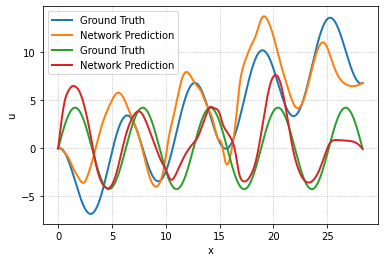

In [7]:
x_test = torch.linspace(0, 9*pi, 10000).reshape(-1,1)
t_test = torch.ones((10000,1))
test = torch.cat([x_test, t_test],1)
u_test = exact_solution_u(x_test, t_test).reshape(-1,1)
p_test = exact_solution_p(x_test, t_test).reshape(-1,1)
my_network = my_network.cpu()
w_test_pred = my_network(test)
u_test_pred = w_test_pred[:,0].reshape(-1,1)
p_test_pred = w_test_pred[:,1].reshape(-1,1)

plt.grid(True, which="both", ls=":")
plt.plot(x_test, u_test, label="Ground Truth",lw=2)
plt.plot(x_test, u_test_pred.detach(), label="Network Prediction",lw=2)
plt.xlabel("x")
plt.ylabel("u")
plt.legend()

# Compute the relative L2 error norm (generalization error)
relative_error_test = torch.mean((u_test_pred - u_test)**2)/torch.mean(u_test**2)
#relative_error_test = torch.max(torch.abs(u_test_pred -u_test))/torch.max(torch.abs(u_test))
print("Relative Error Test: ", relative_error_test.detach().numpy()*100, "%")

plt.grid(True, which="both", ls=":")
plt.plot(x_test, p_test, label="Ground Truth",lw=2)
plt.plot(x_test, p_test_pred.detach(), label="Network Prediction",lw=2)
plt.xlabel("x")
plt.ylabel("u")
plt.legend()

# Compute the relative L2 error norm (generalization error)
relative_error_test = torch.mean((p_test_pred - p_test)**2)/torch.mean(p_test**2)
#relative_error_test = torch.max(torch.abs(u_test_pred -u_test))/torch.max(torch.abs(u_test))
print("Relative Error Test: ", relative_error_test.detach().numpy()*100, "%")